First application of a random forest algorithm on our prepared datasets

In [2]:
#imports
import pandas as pd 
import numpy as np  
import sklearn
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import shuffle
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from joblib import dump, load
import statistics

We want to train our algorithm on 2 seasons, and then test it out on the next season.
The first day of each season is not taken into account because there is no statistics on the team yet
To be able to train on multiple years despite the fact that teams in L1 are changing, we do not use the name of the team in our algorithm but only the statistics at a precise moment of the season.

In [113]:
#Preparing the data
df0= pd.read_csv('../CleanedDatasets/2015_2016_cleaned.csv')
df1 = pd.read_csv('../CleanedDatasets/2016_2017_cleaned.csv')
df2 = pd.read_csv('../CleanedDatasets/2017_2018_cleaned.csv')
df3 = pd.read_csv('../CleanedDatasets/2018_2019_cleaned.csv')

df0 = df0[10:]
df1 = df1[10:]
df2 = df2[10:]
df3 = df3[50:]

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df0 = df0.dropna()

df1 = df1.drop(['Unnamed: 0','Div','Date','HomeTeam','AwayTeam'], axis=1)
df2 = df2.drop(['Unnamed: 0','Div','Date','HomeTeam','AwayTeam'],axis=1)
df3 = df3.drop(['Unnamed: 0','Div','Date','HomeTeam','AwayTeam'],axis=1)
df0 = df0.drop(['Unnamed: 0','Div','Date','HomeTeam','AwayTeam'],axis=1)

df1 = df1.reset_index(drop =True)
df2 = df2.reset_index(drop =True)
df3 = df3.reset_index(drop =True)
df0 = df0.reset_index(drop =True)
df0 = df0.astype({'FTR': 'int64'})

frames = [df1,df2]
df = pd.concat(frames,ignore_index=True)

df3_cotes_raw = pd.read_csv('../DataSets/2018_2019.csv')
df3_cote = pd.DataFrame()
df3_cote['B365H']=df3_cotes_raw['B365H']
df3_cote['B365D']=df3_cotes_raw['B365D']
df3_cote['B365A']=df3_cotes_raw['B365A']

df3_cote = df3_cote.iloc[50:]
df3_cote = df3_cote.reset_index(drop=True)


In [114]:
#We create our train et test sets, the label column is indeed the 'FTR' (Full Time Result) which is an int 0,1,2 for AwayTeamWin, Draw, HomeTeamWin
X_train = list(np.array(df.drop(['FTR'],axis=1)))
y_train = list(np.array(df['FTR']))

X_test = list(np.array(df3.drop(['FTR'],axis=1)))
y_test = list(np.array(df3['FTR']))

In [105]:
clf= RandomForestClassifier(n_estimators=200)
clf=clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5060606060606061

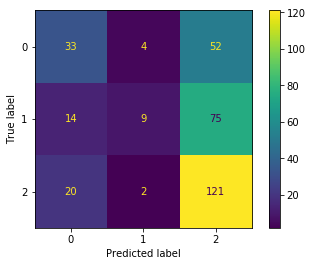

In [46]:
plot_confusion_matrix(clf,X_test,y_test)

Nous obtenons une précision sur les prédictions autour des 50%. C'est un résultat qui reste assez bas mais qui est encourageant (au moins au dessus de 33% qui correspondrait à 1/3 avec une prédictions au hasard)

Pour voir si nos précisions sont déjà meilleures qu'un parieur lambda, nous avons simulé une année de pari sur 2018_2019 en suivant les prédictions et avec les cotes d'un site de pari nommé bet365

In [106]:
def simule_annee_pari(classifier, df_cote_test, X_test, y_test, basebet=10):
    bankroll = 0
    predictions = classifier.predict(X_test)
    for i in range(len(y_test)):
        if predictions[i]==y_test[i]:
            if predictions[i]==2:
                bankroll+=basebet*df_cote_test['B365H'].iloc[i]
            if predictions[i]==1:
                bankroll+=basebet*df_cote_test['B365D'].iloc[i]
            if predictions[i]==0:
                bankroll+=basebet*df_cote_test['B365A'].iloc[i]
        
    return (bankroll-len(y_test)*basebet)

print(simule_annee_pari(clf,df3_cote,X_test,y_test))

141.09999999999945


On trouve un résultat qui dépend de la RandomForest générée, en effet, ce classifier étant lié à l'aléatoire dans sa génération, les scores varient pour chaque génération avec une moyenne autour des 0.48. Les Forest avec un score au dessus de 0.5 vont faire une année rentable, tandis que les forets en dessous de 0.49 vont nous amener à une perte d'argent.

Nous avons tout d'abord pensé à générer plusieurs forets, puis choisir le résultat qui est le plus fréquent dans les prédictions obtenues :

In [29]:
list_of_forest=[]
for i in range(100):
    clf= RandomForestClassifier(n_estimators=100)
    clf=clf.fit(X_train,y_train)
    list_of_forest.append(clf)

In [33]:
list_of_prediction = []
for i in list_of_forest:
    list_of_prediction.append(i.predict(X_test))

In [39]:
import random
def mean_guess(list_of_prediction,idx):    
    nb2=0
    nb1=0
    nb0=0
    for j in list_of_prediction:
        if j[idx]==2:
            nb2+=1
        if j[idx]==1:
            nb1+=1
        if j[idx]==0:
            nb0+=1
    if nb2>nb1 and nb2>nb0:
        return 2
    if nb1>nb2 and nb1>nb0:
        return 1 
    if nb0>nb2 and nb0>nb1:
        return 0
    if nb0==nb1 and nb2>nb0:
        return 2
    else:
        return random.choice([0,1])
    if nb0==nb2 and nb1>nb0:
        return 1
    else:
        return random.choice([0,2])
    if nb1==nb2 and nb0>nb1:
        return 0
    else:
        return random.choice([1,2])
    if nb1==nb2==nb0:
        return random.choice([0,1,2])

In [44]:
good_guess=0
for idx, i in enumerate(y_test):
    if mean_guess(list_of_prediction,idx)==i:
        good_guess+=1
print(good_guess/len(y_test))


0.48484848484848486


Mais à l'aide de cette méthode, on obtient un score qui se rapproche du score moyen des forêts générées, ce qui tourne autour de 0.49 et n'est pas très satisfaisant.

On peut ensuite choisir de générer plusieurs forêts puis de prendre celle avec le meilleur score.

In [117]:
best_tree = 0
current_best_score = 0
list_score=[]
for i in range(200):
    #clf=tree.DecisionTreeClassifier()
    clf= RandomForestClassifier(n_estimators=100)
    clf=clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    list_score.append(score)
    if score> current_best_score:
        current_best_score=score
        best_tree=clf
        print("current best score :", current_best_score)
print("average",statistics.mean(list_score))

current best score : 0.48787878787878786
current best score : 0.503030303030303
current best score : 0.5181818181818182
average 0.4786969696969697


In [120]:
print(simule_annee_pari(best_tree,df3_cote, X_test, y_test))

224.30000000000018
